Created by Zsolt Elter (2019)

# Group cross sections

The objectives of this notebook are the following:

- Display a simplified model of the neutron spectrum
- Demonstrate how group cross sections can be created

Exercise at the end!


## A simplified LWR spectrum

As a simplification let us consider the neutron spectrum ad the product of a normalized energy distribution function and the flux, a dimensioned quantity.

The distribution function is split in three components.

__Thermal component__: described by the Maxwell-distribution

$$f_{th}(E)=\alpha_{th}E\exp\big(-\frac{E}{kT}\big)$$

where $\alpha_{th}$ is a normalization constant, $k$ is the Boltzmann-constant, $T$ is the thermodynamical temperature (in K) and $E$ is the energy (in eV).

__Epithermal compontent__: Described by a $1/E$ slope within a piecewise function to account for the thermal and fast limit values:

\begin{equation}
    f_{epi}(E) = 
    \begin{cases}
      \alpha_{epi}\frac{E^2-E_0^2}{E(E_1^2-E_0^2)} & \text{if $E_0\leq E \leq E_1$} \\
      \alpha_{epi}\frac{1}{E} & \text{if $E_1\leq E \leq E_2$} \\
      \alpha_{epi}\frac{E^2-E_3^2}{E(E_2^2-E_3^2)} & \text{if $E_2\leq E \leq E_3$} \\
      0 & \text{else}
    \end{cases}
\end{equation}

Where $\alpha_{epi}$ is a normalization constant, and the energy limits are chosen to be $E_0=0 eV$, $E_1=0.2 eV$ $E_2=0.25 eV$ and $E_3=1 MeV$

__Fast component__: corresponds to the fisson-spectrum (also known as Watt-spectrum) described by the following empirical formula:

$$f_{fast}(E)=\alpha_{fast}\exp\big(-\frac{E}{a}\big)\sinh(\sqrt{bE})$$

where $\alpha_{fast}$ is a normalization constant and for U-235 the parameters are $a=9.65\cdot 10^5 eV$ and $b=2.29\cdot 10^{-6} eV^{-1}$. But in the example we will use slightly different values (since the fission does not happen only in U-235).

The normalization is done so that $\int_0^\infty f_{th}(E)dE=\int_0^\infty f_{epi}(E)dE=\int_0^\infty f_{fast}(E)dE=1$. In practice this means that the above defined distributions will be divided by their integral.

Finally the spectrum will be a sum of these components whit some appropriate flux values:

$$\Phi(E) = \Phi_{th}f_{th}(E) + \Phi_{epi}f_{epi}(E) + \Phi_{fast}f_{fast}(E)$$.

For the following let's consider the constants to be

- $\Phi_{th} = 3.2\cdot 10^{14}$ ncm$^{-2}$s$^{-1}$
- $\Phi_{epi} = 1.98\cdot 10^{14}$ ncm$^{-2}$s$^{-1}$
- $\Phi_{fast} = 0.98\cdot 10^{14}$ ncm$^{-2}$s$^{-1}$
- $T=325$ K
- $a=8.09\cdot 10^5$ eV
- $b=9.32\cdot 10^{-7}$ eV$^{-1}$

These values and the model are taken from NIMA Vol 593 pp510-518 (https://www.sciencedirect.com/science/article/pii/S016890020800795X), and describe the spectrum in the BR2 reactor in Mol, Belgium. Nevertheless the structure gives a fair representation of any reactor spectrum if appropriate flux values are provided. One can browse some reference spectra to see similar characteristics. The main lack is in this model the sudden decreases in the resonance region characteristic to certain reactor materials eg. due the elastic scattering of Na-23 (https://www.nuclear-power.net/wp-content/uploads/2016/01/thermal-vs-fast-reactor-neutron-spectrum-min.png).

Let us implement this spectrum as a function of energy. Don't be afraid to play around with the parameters to see how it changes the spectrum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def getSpectrum(energy):
    """Approximating the spectrum as in NIMA Vol 593 pp510-518 paper. 
    Constants describing the flux are taken from the same paper"""
    #thermal
    fth=[]
    k=8.6173324e-5 #eV/K
    T=325 #K
    for E in energy:
        fth.append(E*np.exp(-E/(k*T)))   #who needs pythonic way?
    energy=np.array(energy)
    fth=np.array(fth)
    fth=fth/np.trapz(fth,energy) #normalize
    
    #epithermal
    fepi=[]
    E0=0
    E1=0.2
    E2=0.25e6
    E3=1e6
    for E in energy:
        if E0<=E and E<E1:
            fepi.append((E**2-E0**2)/(E*(E1**2-E0**2)))
        elif E1<=E and E<E2:
            fepi.append(1/E)
        elif E2<=E and E<E3:
            fepi.append((E**2-E3**2)/(E*(E2**2-E3**2)))
        else:
            fepi.append(0.0)
    fepi=np.array(fepi)
    fepi=fepi/np.trapz(fepi,energy)
    
    #fast
    ffast=[]
    a=8.09e5 #u235 9.65e5
    b=9.32e-7 #u235 2.29e-6
    for E in energy:
        ffast.append(np.exp(-E/a)*np.sinh(np.sqrt(b*E)))
    ffast=np.array(ffast)
    ffast=ffast/np.trapz(ffast,energy)
    
    #create real spectrum
    PhiTh=3.2e14
    PhiEpi=1.98e14
    PhiFast=0.98e14
    
    phi=PhiTh*fth+PhiEpi*fepi+PhiFast*ffast
    #let's return all the components separetaly for plotting. But in practice "return phi" is enough
    return phi, PhiTh*fth,PhiEpi*fepi,PhiFast*ffast

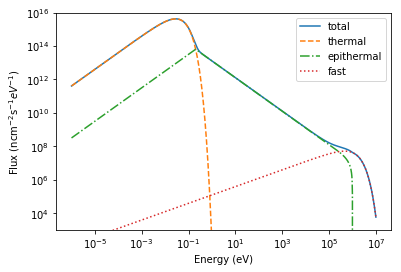

In [2]:
energy=np.logspace(-6,7,1000) #in eV
spectrum,spectrumTh,spectrumEpi,spectrumFast=getSpectrum(energy)

plt.loglog(energy,spectrum,label='total')
plt.ylim([1e3,1e16])
plt.loglog(energy,spectrumTh,'--',label='thermal')
plt.loglog(energy,spectrumEpi,'-.',label='epithermal')
plt.loglog(energy,spectrumFast,':',label='fast')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel(r'Flux (ncm$^{-2}$s$^{-1}eV^{-1}$)')
plt.show()

## Group cross sections

Microscopic cross sections are continous function of the incoming neutron energy E. However, in practice one often needs to discretize it into one or more groups. The group cross sections are the spectrum weighted average of the cross sections:

$$\sigma_g=\frac{\int_{E_{g}}^{E_{g-1}}\sigma(E)\Phi(E)dE}{\int_{E_{g}}^{E_{g-1}}\Phi(E)dE}$$

Where $g$ stands for the group. In case of a one-group approximation the integral is performed from $0$ to $\infty$.

Note that the energy dependent flux needs to be a priori known for calculating the group cross sections, and in fact usually we want to know the group cross sections to calculate the flux. This is the beauty of reactor physics. Back in the days group constants were often known from experiments. Today a common method is to generate group constants from time consuming Monte Carlo methods, and then use them in fast deterministic calculations.

### One group fission cross section of U-235 and U238

One can access microscopic cross section data from many sources (eg. http://atom.kaeri.re.kr/nuchart/). 

Cross sections can be copied from there and put into python arrays or list, or into a file and then the file can be read. 

Here one solution is provided which makes use of the urllib library and send a request to the server, which then sends back the HTML content of the webpage (as a browser would communicate to a server). Getting a response might take couple of seconds. Then a function getXS is provided which helps reading cross section data from this HTML content. There are other, probably better solutions to do this.

We will read the fission cross sections from the data library JEFF3.2.


In [3]:
def getXS(content):
    """getting data from the html content. I tried to avoid Beautiful soup.
    the content has a shape as follows like:    
    Energy(eV) XS(b)<br>
    1.00000E-05 3.07139<br>"""
    energy=[]
    xs=[]
    flag=False
    i=0
    for line in content:
        x=line.strip().split()
        if  x[0]==b'Energy(eV)':
            flag=True
            continue
        if x[0]==b'</span>':
            flag=False
        if flag:
            energy.append(float(x[0]))
            xs.append(float(x[1][:-4]))
    return np.array(energy), np.array(xs)

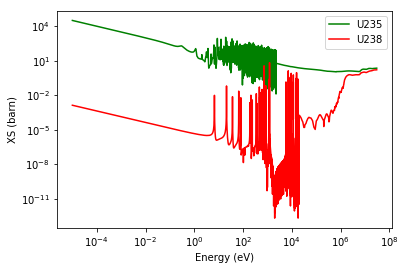

In [4]:
import urllib.request

website235='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'
website238='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,238,9237,3,18'

with urllib.request.urlopen(website235) as response:
    content235 = response.readlines()
energy235,xs235=getXS(content235)

with urllib.request.urlopen(website238) as response:
    content238 = response.readlines()
energy238,xs238=getXS(content238)

plt.figure()
plt.loglog(energy235,xs235, 'g', label='U235')
plt.loglog(energy238,xs238, 'r', label='U238')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('XS (barn)')
plt.show()

Finally one can weight the cross section with the spectrum and calculate the one group cross section.

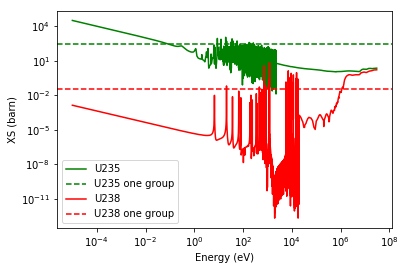

259.50268699608887
0.032046239923730936


In [5]:
spectrum235,spectrumTh235,spectrumEpi235,spectrumFast235=getSpectrum(energy235)
spectrum238,spectrumTh238,spectrumEpi238,spectrumFast238=getSpectrum(energy238)

sigma_fiss_U235=np.trapz(xs235*spectrum235,energy235)/np.trapz(spectrum235,energy235)
sigma_fiss_U238=np.trapz(xs238*spectrum238,energy238)/np.trapz(spectrum238,energy238)

plt.figure()
plt.loglog(energy235,xs235, 'g', label='U235')
plt.axhline(sigma_fiss_U235,c='g',ls='--',label='U235 one group')
plt.loglog(energy238,xs238, 'r', label='U238')
plt.axhline(sigma_fiss_U238,c='r',ls='--',label='U238 one group')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('XS (barn)')
plt.show()

print(sigma_fiss_U235)
print(sigma_fiss_U238)

# Exercise

Calculate the group cross sections in the thermal and fast groups to compare $\sigma_{f}/\sigma_{tot}$ values for Pu-239, Pu-240, Pu-242. Discuss what might be an advantage of fast reactors?

hint: 
- you can interpolate the cross sections to evaluate it in other energies.
- 'http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,238,9237,3,18' the URL has some structure: 9237: MAT number, 18: MT number. One can write a generic string and put these numbers there for the several cases.
- Avoid repeating the same code snippet as in this notebook when sending the request. Rather place info and results in nested dictionaries (example for possible stucture below, though you probably will not create like this, but on the fly), and iterate through that.



In [6]:
data={'U235fiss': {'Z':92, 'A':235,'MAT':9228,'MT':18,'energy':energy235,'xs':xs235,'sigma':sigma_fiss_U235},
     'U238fiss': {'Z':92, 'A':238,'MAT':9237,'MT':18,'energy':energy238,'xs':xs238,'sigma':sigma_fiss_U238}}
data['U235fiss']['xs']

array([3.14119e+04, 2.80953e+04, 2.56471e+04, ..., 2.21460e+00,
       2.22251e+00, 2.22970e+00])